In [48]:
import ccxt
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# -----------------------------------------------------------------------------
# Configuration
# -----------------------------------------------------------------------------
SYMBOL = 'ETH/USDT'
TIMEFRAME = '4h'  # 1-hour candles
LIMIT = 1000      # Number of candles to fetch

# Initialize Exchange (Public API)
exchange = ccxt.binance({
    'enableRateLimit': True, 
})

print(f"✅ Initialized {exchange.name} successfully.")

✅ Initialized Binance successfully.


In [49]:
def fetch_historical_data(symbol, timeframe, limit):
    """
    Fetches OHLCV data and returns a clean Pandas DataFrame.
    """
    print(f"Fetching {limit} {timeframe} candles for {symbol}...")
    
    # fetch_ohlcv returns a list of lists
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe, limit=limit)
    
    # Load directly into DataFrame (Fixes the read_json error)
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    
    # Convert timestamp to datetime and set index
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('datetime', inplace=True)
    
    # Ensure numeric types
    numeric_cols = ['open', 'high', 'low', 'close', 'volume']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, axis=1)
    
    return df

# Run the function
df = fetch_historical_data(SYMBOL, TIMEFRAME, LIMIT)
print(f"Data Loaded: {df.shape}")
display(df.head(3))

Fetching 1000 4h candles for ETH/USDT...
Data Loaded: (1000, 6)


,timestamp,open,high,low,close,volume
datetime,,,,,,
2025-08-15 04:00:00,1755230400000,4634.47,4662.60,4599.01,4640.16,91121.5734
2025-08-15 08:00:00,1755244800000,4640.15,4666.66,4612.31,4634.16,69832.2749
2025-08-15 12:00:00,1755259200000,4634.17,4672.67,4395.47,4430.86,301257.0493


In [50]:
# -----------------------------------------------------------------------------
# 2. Feature Engineering
# -----------------------------------------------------------------------------
# 1. Log Returns
df['log_returns'] = np.log(df['close'] / df['close'].shift(1))

# 2. Standard Technical Indicators
df.ta.rsi(length=14, append=True)
df.ta.macd(fast=12, slow=26, signal=9, append=True)
df.ta.atr(length=14, append=True)

# --- NEW FEATURES ---

# A. Lagged Features
df['RSI_Lag1'] = df['RSI_14'].shift(1)
df['Return_Lag1'] = df['log_returns'].shift(1)

# B. Volume Context (OBV)
df.ta.obv(append=True)
df['OBV_Slope'] = df['OBV'].diff()

# C. Volatility Context (Bollinger Bands)
# We generate the bands
df.ta.bbands(length=20, std=2, append=True)

# --- THE FIX: Robust Renaming ---
# Find the column that starts with 'BBP' (Bollinger Band Percentage)
# It might be named 'BBP_20_2.0' or 'BBP_20_2' depending on version
bbp_cols = [c for c in df.columns if c.startswith('BBP_')]
if bbp_cols:
    actual_col_name = bbp_cols[0]
    df.rename(columns={actual_col_name: 'BBP'}, inplace=True)
    print(f"✅ Renamed '{actual_col_name}' to 'BBP'")
else:
    print("⚠️ Warning: Bollinger Bands BBP column not found!")

# -----------------------------------------------------------------------------
# 3. Cleanup
# -----------------------------------------------------------------------------
df.dropna(inplace=True)
print("Columns available:", df.columns.tolist())

✅ Renamed 'BBP_20_2.0_2.0' to 'BBP'
Columns available: ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'log_returns', 'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'ATRr_14', 'RSI_Lag1', 'Return_Lag1', 'OBV', 'OBV_Slope', 'BBL_20_2.0_2.0', 'BBM_20_2.0_2.0', 'BBU_20_2.0_2.0', 'BBB_20_2.0_2.0', 'BBP']


In [51]:
# -----------------------------------------------------------------------------
# 3. Define the Target (The Label)
# -----------------------------------------------------------------------------
# We want to predict if the NEXT candle's return is > Threshold
# Since you are on 4H candles now, we use 0.5% as the target
TARGET_THRESHOLD = 0.005 

# Shift(-1) looks into the future to create the label
df['target_direction'] = (df['log_returns'].shift(-1) > TARGET_THRESHOLD).astype(int)

# The shift created a NaN at the very last row (future is unknown). Drop it.
df.dropna(inplace=True)

print(f"✅ Target Defined. Threshold: {TARGET_THRESHOLD}")
print("Class Balance:\n", df['target_direction'].value_counts())

✅ Target Defined. Threshold: 0.005
Class Balance:
 target_direction
0    696
1    271
Name: count, dtype: int64


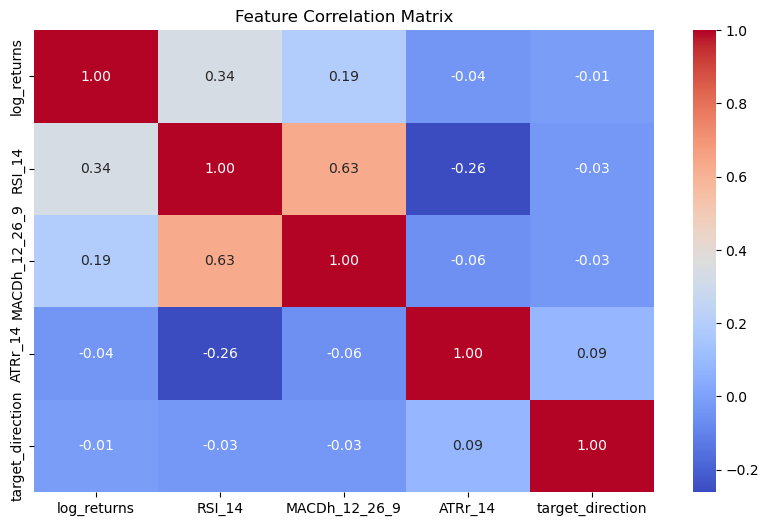

In [52]:
# Select features to visualize
features = ['log_returns', 'RSI_14', 'MACDh_12_26_9', 'ATRr_14', 'target_direction']

plt.figure(figsize=(10, 6))
sns.heatmap(df[features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

Training with Time Series Cross-Validation...

Fold 1: Accuracy = 0.6025
Fold 2: Accuracy = 0.6584
Fold 3: Accuracy = 0.6335
Fold 4: Accuracy = 0.7578
Fold 5: Accuracy = 0.7764

Average Accuracy: 0.6857


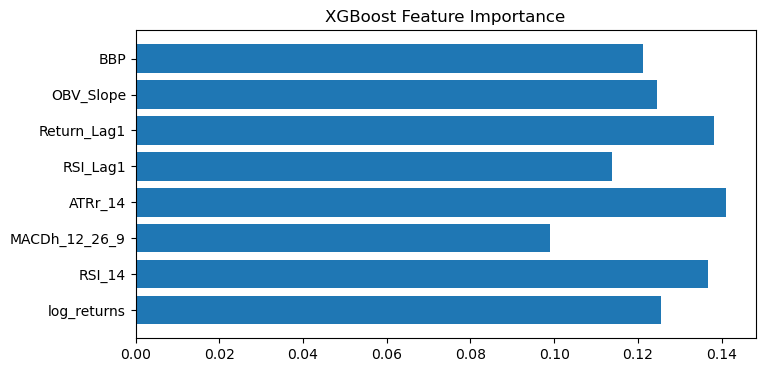

In [53]:
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, classification_report

# Setup Features (X) and Target (y)
# DEFINE THE FEATURES
# Setup Features (X) and Target (y)
feature_cols = [
    'log_returns', 
    'RSI_14', 
    'MACDh_12_26_9', 
    'ATRr_14', 
    'RSI_Lag1',       
    'Return_Lag1',    
    'OBV_Slope',      
    'BBP'             # <--- UPDATED: Use the simple name here
]

X = df[feature_cols]
y = df['target_direction']

# Time Series Split (5 Folds)
tscv = TimeSeriesSplit(n_splits=5)
model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, eval_metric='logloss', random_state=42)

print("Training with Time Series Cross-Validation...\n")

fold = 1
accuracies = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    acc = accuracy_score(y_test, preds)
    accuracies.append(acc)
    print(f"Fold {fold}: Accuracy = {acc:.4f}")
    fold += 1

print(f"\nAverage Accuracy: {np.mean(accuracies):.4f}")

# Feature Importance Plot
plt.figure(figsize=(8, 4))
plt.barh(feature_cols, model.feature_importances_)
plt.title("XGBoost Feature Importance")
plt.show()

<Figure size 600x600 with 0 Axes>

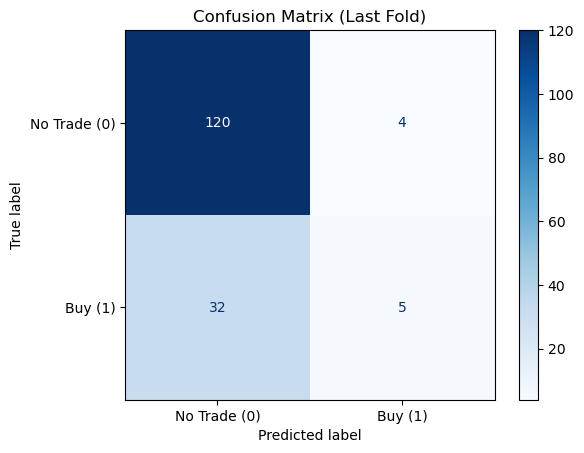

--- Strategy Performance (Threshold > 0.25) ---
Precision: 0.1905 (Win Rate)
Trades Taken: 84 (out of 161 hours)


In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Confusion Matrix (Last Fold)
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Trade (0)', 'Buy (1)'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix (Last Fold)')
plt.show()

# 2. Probability Threshold Tuner
# We filter for high-confidence trades only.
probs_up = model.predict_proba(X_test)[:, 1]

# Try changing this to see how precision improves!
CONFIDENCE_THRESHOLD = 0.25

custom_preds = (probs_up > CONFIDENCE_THRESHOLD).astype(int)
new_prec = precision_score(y_test, custom_preds, zero_division=0)
num_trades = np.sum(custom_preds)

print(f"--- Strategy Performance (Threshold > {CONFIDENCE_THRESHOLD}) ---")
print(f"Precision: {new_prec:.4f} (Win Rate)")
print(f"Trades Taken: {num_trades} (out of {len(y_test)} hours)")

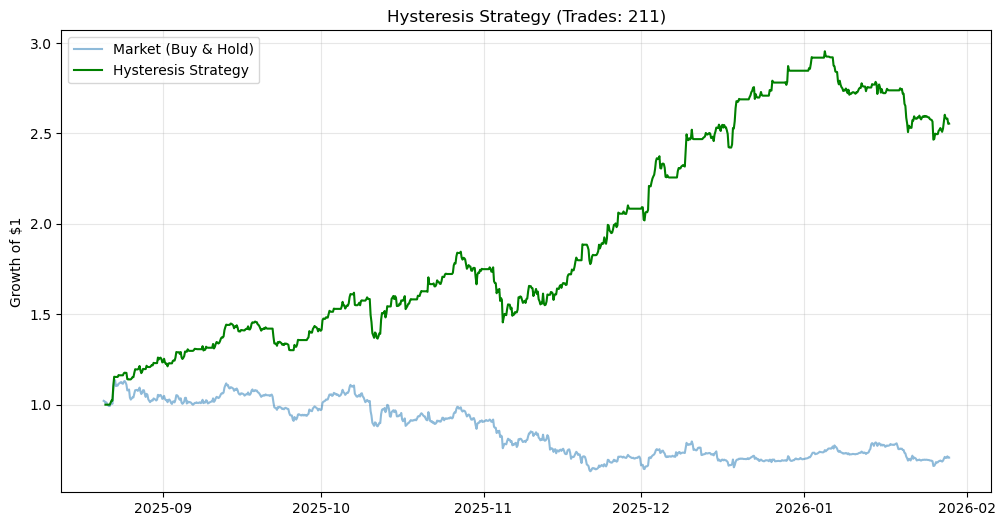

Total Return: 155.47%
Total Fees Paid: 21.10%
Trade Count: 211


In [55]:
# -----------------------------------------------------------------------------
# 7. Advanced Backtest (Hysteresis / Smoothing)
# -----------------------------------------------------------------------------

# Parameters
UPPER_THRESHOLD = 0.30  # Buy when confident
LOWER_THRESHOLD = 0.15  # Sell only when signal is weak
FEE_RATE = 0.001        # 0.1%

# 1. Generate Raw Probabilities
probs = model.predict_proba(X)[:, 1]

# 2. Hysteresis Loop
# We need to iterate because current position depends on PREVIOUS position
positions = []
current_pos = 0

for p in probs:
    if p > UPPER_THRESHOLD:
        current_pos = 1  # Enter Long
    elif p < LOWER_THRESHOLD:
        current_pos = 0  # Exit / Cash
    else:
        # p is between 0.15 and 0.30
        # KEEP PREVIOUS POSITION (Do nothing)
        pass 
    
    positions.append(current_pos)

# 3. Create DataFrame Columns
df['signal'] = positions
df['signal'] = df['signal'].shift(1) # Shift to apply to NEXT candle

# 4. Calculate PnL
df['strategy_raw'] = df['signal'] * df['log_returns']
df['trades'] = df['signal'].diff().abs()
df['strategy_net'] = df['strategy_raw'] - (df['trades'] * FEE_RATE)

df['cumulative_market'] = df['log_returns'].cumsum().apply(np.exp)
df['cumulative_strategy'] = df['strategy_net'].cumsum().apply(np.exp)

# 5. Stats
total_return = df['cumulative_strategy'].iloc[-1] - 1
total_fees = (df['trades'].sum() * FEE_RATE)
trade_count = df['trades'].sum()

# 6. Visualization
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['cumulative_market'], label='Market (Buy & Hold)', alpha=0.5)
plt.plot(df.index, df['cumulative_strategy'], label='Hysteresis Strategy', color='green')

plt.title(f"Hysteresis Strategy (Trades: {int(trade_count)})")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Total Return: {total_return:.2%}")
print(f"Total Fees Paid: {total_fees:.2%}")
print(f"Trade Count: {int(trade_count)}")

In [56]:
# Filter for only the hours where we were holding the position
active_hours = df[df['signal'] == 1].copy()

# 1. Active Accuracy (Do we hold during Green candles?)
active_win_rate = (active_hours['log_returns'] > 0).mean()

# 2. Average Hourly Return (Quality of hold)
avg_active_return = active_hours['log_returns'].mean()
avg_market_return = df['log_returns'].mean()

print(f"--- Hysteresis Performance Diagnostics ---")
print(f"Active Candle Win Rate: {active_win_rate:.2%}")
print(f"Avg Return per Active Hour: {avg_active_return:.5f}")
print(f"Avg Return per Market Hour: {avg_market_return:.5f}")

if avg_active_return > avg_market_return:
    print("✅ Conclusion: You are holding during better-than-average times.")
else:
    print("❌ Conclusion: You are holding through too much noise/downturns.")

--- Hysteresis Performance Diagnostics ---
Active Candle Win Rate: 57.87%
Avg Return per Active Hour: 0.00201
Avg Return per Market Hour: -0.00036
✅ Conclusion: You are holding during better-than-average times.


In [57]:
# Save the trained model to a file
model.save_model("model.json")
print("✅ Model saved to model.json")

✅ Model saved to model.json
